# Starbucks Capstone Challenge

# 1. Business Understanding:

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [259]:
pd.options.mode.chained_assignment = None 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# 2. Data Understanding:
    - in the following cells we will explore each table and confirm if it is inline with the given dictionary and look for gaps

## a. portfolio:

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info() #null and data type check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio['id'].nunique() #no duplicates

10

In [7]:
# fine different values in offer_tpe columns and counts:
portfolio.groupby('offer_type')['id'].count() 

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [8]:
duration = portfolio.groupby('duration')['id'].count()

Text(0.5, 1.0, 'Visual of number of days offer was up')

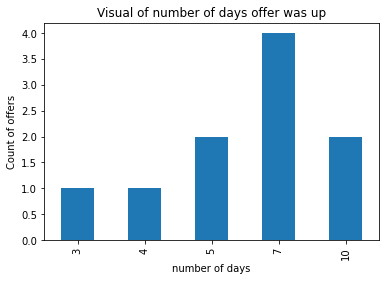

In [9]:
plt.figure()
duration.plot(kind='bar')
plt.xlabel("number of days")
plt.ylabel("Count of offers")
plt.title("Visual of number of days offer was up")

In [10]:
difficulty = portfolio.groupby('difficulty')['id'].count()

Text(0.5, 1.0, 'Visual of count of offers vs. spend')

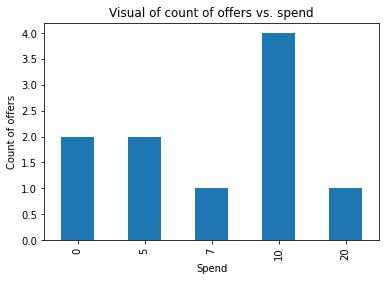

In [11]:
plt.figure()
difficulty.plot(kind='bar')
plt.xlabel("Spend")
plt.ylabel("Count of offers")
plt.title("Visual of count of offers vs. spend")

In [12]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [13]:
#identifying different channels
channels = []
portfolio["channels"][0]
for i in range(len(portfolio)):
    for chnl in portfolio["channels"][i]:
        if chnl in channels:
            pass
        else:
            channels.append(chnl)

channels

['email', 'mobile', 'social', 'web']

In [14]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Findings:
- portfolio table consist of 10 rows and 6 columns, has no null values
- has 10 distinct ids, meaning there are no duplicates
- there are three different offer types: {BOGO, discount and informational}
- of the 10 offers, 4 are BOGO, 4 are discount and 2 informational
- most offers had a duration of 7 days
- most offers involved a spend of 10
- different channels are: {'email', 'mobile', 'social', 'web'}

## b. profile:

In [15]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [16]:
profile.shape

(17000, 5)

In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [18]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [19]:
profile['id'].nunique() #no duplicates

17000

In [20]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


- maximum value of age is 118, which is an outlier affecting the entire distribution as shown below:

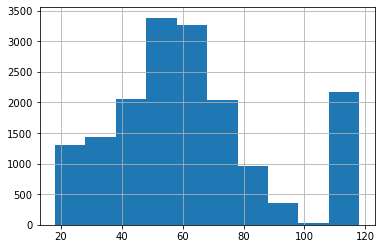

In [21]:
profile['age'].hist()

In [22]:
profile['age'].value_counts().sort_values(ascending = False)

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [23]:
profile[profile['age']==118]['income'].unique()

array([nan])

In [24]:
profile[profile['age']==118]['gender'].unique()

array([None], dtype=object)

- after chacking for nulls, we found that both income and gender have 2175 missing values
- and based on the above we have 2175 age values set as 118 
- meaning that we have gaps in 2175 rows in our dataset 

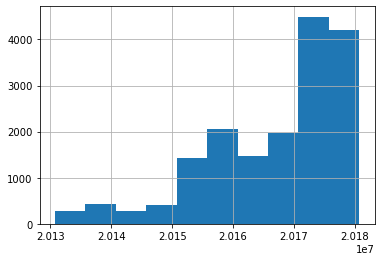

In [25]:
profile['became_member_on'].hist()

 - most members joined after the start of 2017

In [26]:
gender_dist = profile['gender'].value_counts()
gender_dist

M    8484
F    6129
O     212
Name: gender, dtype: int64

Text(0.5, 1.0, 'Gender distribution')

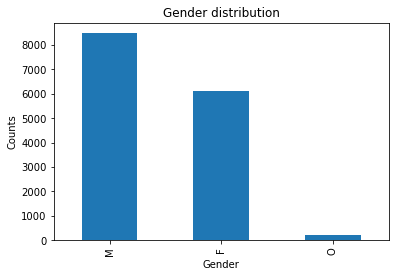

In [27]:
plt.figure()
gender_dist.plot(kind='bar')
plt.xlabel("Gender")
plt.ylabel("Counts")
plt.title("Gender distribution")

In [28]:
gender_dist['M']/profile['gender'].value_counts().sum() * 100

57.227655986509276

In [29]:
gender_dist['F']/profile['gender'].value_counts().sum() * 100

41.342327150084316

In [30]:
profile[profile['age']!=118]['age'].sort_values(ascending = False)

1556     101
16864    101
14846    101
4100     101
15800    101
        ... 
750       18
2270      18
5906      18
6763      18
4016      18
Name: age, Length: 14825, dtype: int64

In [31]:
profile[profile['age']!=118]['age'].sort_values(ascending = True)

4016      18
6763      18
5906      18
2270      18
750       18
        ... 
15800    101
4100     101
14846    101
16864    101
1556     101
Name: age, Length: 14825, dtype: int64

#### Findings:
- profile tables holds the demographics of users, it has 17000 rows and 5 columns
- it is clear to see that gender and income columns have 2175 missing values
- looking at the id column having 17000 unique values, means that we dont have duplicate rows in profile table
- looking at the statistics of our table, we find that age column has maximum value of 118 representing an outlier that affects the distribution of remaining values
- after looking closely into the value counts in age column we find that 2175 rows have value of 118. Looking further into these rows we find that they have null values for age and gender
- most members joined after the start of 2017
- excluding the 2175 rows, 57% of profiles in our dataset are males, and 41% are females. however, 212 profiles have set their gender as 'O'
- youngest of customers in our dataset is 18 and eldest is 101

## c. transcript:

In [32]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [33]:
transcript.shape

(306534, 4)

In [34]:
transcript.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [35]:
transcript.isnull().sum() # no nulls

person    0
event     0
value     0
time      0
dtype: int64

In [36]:
transcript.columns.duplicated().sum() # no duplicates

0

In [37]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Text(0.5, 1.0, 'events distribution')

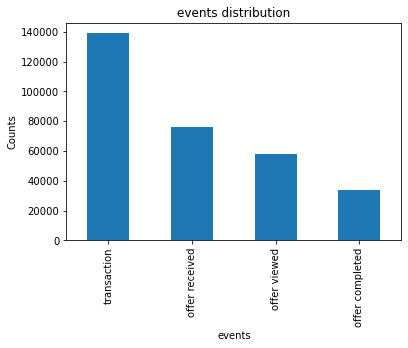

In [38]:
plt.figure()
transcript['event'].value_counts().plot(kind='bar')
plt.xlabel("events")
plt.ylabel("Counts")
plt.title("events distribution")

#### Findings:
- in the transcript table, we have 306534 rows and 4 columns 
- our table has no nulls and no duplicates
- person column has id of user profile
- value column is a dictionary of either an offer id or transaction amount depending on the record
- time column has time in hours since start of test. (since time here is in hours, we have to modify duration column in portfolio table to reflect time in hours instead of days)
- event column has 4 distict values (transaction, offer recieved, offer viewed and offer completed) 
- if event is a transaction, value will hold the amount, otherwise it will hold the id of offer in portfolio table

# 3. Data Preprocessing:
    - Here we will further explore the data to perform some wrangling and preparation for analysis and modeling:

## a. portfolio:

In [40]:
cl_portfolio = portfolio.copy()
cl_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [41]:
# expand the channels column

# we have already identified that the channels column have four unique values: ['email', 'mobile', 'social', 'web']
# create a column for each channel
cl_portfolio['email_channel'] = cl_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
cl_portfolio['mobile_channel'] = cl_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
cl_portfolio['social_channel'] = cl_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
cl_portfolio['web_channel'] = cl_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [42]:
#drop channels column
cl_portfolio.drop('channels', axis='columns', inplace=True)
cl_portfolio

,reward,difficulty,duration,offer_type,id,email_channel,mobile_channel,social_channel,web_channel
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [43]:
# transform unit of duration from days to hours:
cl_portfolio['hrs_duration'] = cl_portfolio['duration'].apply(lambda x: x*24)
cl_portfolio.drop('duration', axis='columns', inplace=True)

cl_portfolio

,reward,difficulty,offer_type,id,email_channel,mobile_channel,social_channel,web_channel,hrs_duration
0,10,10,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,168
1,10,10,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120
2,0,0,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96
3,5,5,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168
4,5,20,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,240
5,3,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,168
6,2,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,240
7,0,0,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,72
8,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,120
9,2,10,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,168


In [44]:
#increase clarity of the dataset by renaming id column to offer_id 
cl_portfolio = cl_portfolio.rename(columns = {'id': 'offer_id'}, inplace = False)
cl_portfolio

,reward,difficulty,offer_type,offer_id,email_channel,mobile_channel,social_channel,web_channel,hrs_duration
0,10,10,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,168
1,10,10,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120
2,0,0,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96
3,5,5,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168
4,5,20,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,240
5,3,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,168
6,2,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,240
7,0,0,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,72
8,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,120
9,2,10,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,168


In [45]:
# replace the categorical offer_ids with numerical values:
offer_id_list = cl_portfolio['offer_id'].astype('category').cat.categories.tolist()
offer_id_dict = {'offer_id' : {i: j for i,j in zip(offer_id_list,list(range(1,len(offer_id_list)+1)))}}
cl_portfolio.replace(offer_id_dict, inplace=True)

In [46]:
cl_portfolio

,reward,difficulty,offer_type,offer_id,email_channel,mobile_channel,social_channel,web_channel,hrs_duration
0,10,10,bogo,8,1,1,1,0,168
1,10,10,bogo,5,1,1,1,1,120
2,0,0,informational,4,1,1,0,1,96
3,5,5,bogo,7,1,1,0,1,168
4,5,20,discount,1,1,0,0,1,240
5,3,7,discount,2,1,1,1,1,168
6,2,10,discount,10,1,1,1,1,240
7,0,0,informational,6,1,1,1,0,72
8,5,5,bogo,9,1,1,1,1,120
9,2,10,discount,3,1,1,0,1,168


In [47]:
# to confirm correct mapping 
offer_id_dict

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [48]:
# to confirm correct mapping 
'ae264e3637204a6fb9bb56bc8210ddfd' == 'ae264e3637204a6fb9bb56bc8210ddfd'

True

## b. profile:

In [49]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [50]:
# while exploring the data, we have identified that customers who have age set as 118,
# also have null values for gender and income, therefore we will remove these rows
cl_profile = profile[profile['age']!=118]
cl_profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [51]:
cl_profile['age'] = cl_profile['age'].astype(int)

In [52]:
# define a new column to categorize customers to different age groups as per universal standard
cl_profile['age_group'] = pd.cut(cl_profile['age'], bins=[0, 12, 18, 35, 60, 103],labels=['child', 'teen', 'young-adult', 'adult', 'elderly'])

In [53]:
cl_profile

,gender,age,id,became_member_on,income,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,adult
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,elderly
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,elderly
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,elderly
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,adult
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,adult
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,elderly
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,adult
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,elderly


In [54]:
# increase clarity of the dataset by renaming id column to customer_id 
cl_profile = cl_profile.rename(columns = {'id': 'customer_id'}, inplace = False)
cl_profile

,gender,age,customer_id,became_member_on,income,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,adult
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,elderly
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,elderly
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,elderly
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,adult
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,adult
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,elderly
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,adult
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,elderly


In [55]:
# replace the categorical ids with numerical values:
customer_id_list = cl_profile['customer_id'].astype('category').cat.categories.tolist()
customer_id_dict = {'customer_id' : {i: j for i,j in zip(customer_id_list,list(range(1,len(customer_id_list)+1)))}}
cl_profile.replace(customer_id_dict, inplace=True)

In [56]:
cl_profile

,gender,age,customer_id,became_member_on,income,age_group
1,F,55,347,20170715,112000.0,adult
3,F,75,6963,20170509,100000.0,elderly
5,M,68,13108,20180426,70000.0,elderly
8,M,65,3247,20180209,53000.0,elderly
12,M,58,2670,20171111,51000.0,adult
...,...,...,...,...,...,...
16995,F,45,6328,20180604,54000.0,adult
16996,M,61,2525,20180713,72000.0,elderly
16997,M,49,94,20170126,73000.0,adult
16998,F,83,9209,20160307,50000.0,elderly


In [57]:
# extract year from became_member_on:
cl_profile['became_member_on'] = pd.to_datetime(cl_profile['became_member_on'], format = '%Y%m%d')
cl_profile['member_since'] = cl_profile['became_member_on'].dt.year
cl_profile

,gender,age,customer_id,became_member_on,income,age_group,member_since
1,F,55,347,2017-07-15,112000.0,adult,2017
3,F,75,6963,2017-05-09,100000.0,elderly,2017
5,M,68,13108,2018-04-26,70000.0,elderly,2018
8,M,65,3247,2018-02-09,53000.0,elderly,2018
12,M,58,2670,2017-11-11,51000.0,adult,2017
...,...,...,...,...,...,...,...
16995,F,45,6328,2018-06-04,54000.0,adult,2018
16996,M,61,2525,2018-07-13,72000.0,elderly,2018
16997,M,49,94,2017-01-26,73000.0,adult,2017
16998,F,83,9209,2016-03-07,50000.0,elderly,2016


In [58]:
# drop became_member_on column
cl_profile.drop('became_member_on', axis='columns', inplace=True)
cl_profile

,gender,age,customer_id,income,age_group,member_since
1,F,55,347,112000.0,adult,2017
3,F,75,6963,100000.0,elderly,2017
5,M,68,13108,70000.0,elderly,2018
8,M,65,3247,53000.0,elderly,2018
12,M,58,2670,51000.0,adult,2017
...,...,...,...,...,...,...
16995,F,45,6328,54000.0,adult,2018
16996,M,61,2525,72000.0,elderly,2018
16997,M,49,94,73000.0,adult,2017
16998,F,83,9209,50000.0,elderly,2016


In [59]:
cl_profile['income'].min()

30000.0

In [60]:
cl_profile['income'].max()

120000.0

In [61]:
# define a new column to categorize customer income to different groups 
cl_profile['income_range'] = pd.cut(cl_profile['income'], bins=[0,29999, 60000, 90000, 120001],labels=['low', 'average', 'above_average', 'high'])

In [62]:
cl_profile

,gender,age,customer_id,income,age_group,member_since,income_range
1,F,55,347,112000.0,adult,2017,high
3,F,75,6963,100000.0,elderly,2017,high
5,M,68,13108,70000.0,elderly,2018,above_average
8,M,65,3247,53000.0,elderly,2018,average
12,M,58,2670,51000.0,adult,2017,average
...,...,...,...,...,...,...,...
16995,F,45,6328,54000.0,adult,2018,average
16996,M,61,2525,72000.0,elderly,2018,above_average
16997,M,49,94,73000.0,adult,2017,above_average
16998,F,83,9209,50000.0,elderly,2016,average


## c. transcript:

In [63]:
cl_transcript = transcript.copy()
cl_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [64]:
# standardize naming convention and change person column name to customer_id
# map the categorical ids to numerics using the dictionary created earlier
cl_transcript = cl_transcript.rename(columns = {'person': 'customer_id'}, inplace = False)
cl_transcript.replace(customer_id_dict, inplace=True)

In [65]:
# increase clarity by renaming the time column to hrs_time:
cl_transcript = cl_transcript.rename(columns = {'time': 'hrs_time'}, inplace = False)
cl_transcript

,customer_id,event,value,hrs_time
0,6963,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,13108,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,10485,transaction,{'amount': 1.5899999999999999},714
306530,6033,transaction,{'amount': 9.53},714
306531,9345,transaction,{'amount': 3.61},714
306532,6864,transaction,{'amount': 3.5300000000000002},714


In [66]:
# splitting the dictionairy in value column to 3 columns offer_id, amount and reward:
cl_transcript = cl_transcript.drop('value',axis=1).join(pd.DataFrame(cl_transcript.value.values.tolist()))
cl_transcript['offer_id'] = cl_transcript['offer_id'].fillna(cl_transcript['offer id'])
cl_transcript.drop('offer id', axis='columns', inplace=True)
cl_transcript

,customer_id,event,hrs_time,amount,offer_id,reward
0,6963,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,13108,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,10485,transaction,714,1.59,NaN,NaN
306530,6033,transaction,714,9.53,NaN,NaN
306531,9345,transaction,714,3.61,NaN,NaN
306532,6864,transaction,714,3.53,NaN,NaN


In [67]:
cl_transcript[cl_transcript['offer_id'].isnull() == True]['event'].unique()

array(['transaction'], dtype=object)

* we can see that null offer ids are associated with transactions, which make sence because these records are not offer. There for we will remove these null values by filling them with the phrase 'Not an Offer'

In [68]:
# fill na
cl_transcript['offer_id'] = cl_transcript['offer_id'].fillna('Not an Offer')

In [69]:
cl_transcript[cl_transcript['offer_id'].isnull() == True]

,customer_id,event,hrs_time,amount,offer_id,reward


In [70]:
# map the categorical offer ids to numerics using the dictionary created earlier
cl_transcript.replace(offer_id_dict, inplace=True)
cl_transcript

,customer_id,event,hrs_time,amount,offer_id,reward
0,6963,offer received,0,NaN,7,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,1,NaN
2,13108,offer received,0,NaN,3,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,10,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,5,NaN
...,...,...,...,...,...,...
306529,10485,transaction,714,1.59,Not an Offer,NaN
306530,6033,transaction,714,9.53,Not an Offer,NaN
306531,9345,transaction,714,3.61,Not an Offer,NaN
306532,6864,transaction,714,3.53,Not an Offer,NaN


In [71]:
cl_transcript[['amount','reward']] = cl_transcript[['amount','reward']].fillna(0)
cl_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  306534 non-null  object 
 1   event        306534 non-null  object 
 2   hrs_time     306534 non-null  int64  
 3   amount       306534 non-null  float64
 4   offer_id     306534 non-null  object 
 5   reward       306534 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB



- we can see that some customer_ids have not been mapped to numerical ids, no need to manipulate these rows as they will be skipped upon merging the datasets together for analysis


In [268]:
cl_transcript

,customer_id,event,hrs_time,amount,offer_id,reward
0,6963,offer received,0,0.00,7,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.00,1,0.0
2,13108,offer received,0,0.00,3,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.00,10,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.00,5,0.0
...,...,...,...,...,...,...
306529,10485,transaction,714,1.59,Not an Offer,0.0
306530,6033,transaction,714,9.53,Not an Offer,0.0
306531,9345,transaction,714,3.61,Not an Offer,0.0
306532,6864,transaction,714,3.53,Not an Offer,0.0


In [72]:
#combine all 3 data sets together:
starbucks_df = cl_transcript.merge(cl_portfolio, on = 'offer_id', how='left')
starbucks_df

,customer_id,event,hrs_time,amount,offer_id,reward_x,reward_y,difficulty,offer_type,email_channel,mobile_channel,social_channel,web_channel,hrs_duration
0,6963,offer received,0,0.00,7,0.0,5.0,5.0,bogo,1.0,1.0,0.0,1.0,168.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.00,1,0.0,5.0,20.0,discount,1.0,0.0,0.0,1.0,240.0
2,13108,offer received,0,0.00,3,0.0,2.0,10.0,discount,1.0,1.0,0.0,1.0,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.00,10,0.0,2.0,10.0,discount,1.0,1.0,1.0,1.0,240.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.00,5,0.0,10.0,10.0,bogo,1.0,1.0,1.0,1.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,10485,transaction,714,1.59,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,6033,transaction,714,9.53,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,9345,transaction,714,3.61,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,6864,transaction,714,3.53,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
starbucks_df = starbucks_df.merge(cl_profile, on = 'customer_id', how='left')
starbucks_df

,customer_id,event,hrs_time,amount,offer_id,reward_x,reward_y,difficulty,offer_type,email_channel,mobile_channel,social_channel,web_channel,hrs_duration,gender,age,income,age_group,member_since,income_range
0,6963,offer received,0,0.00,7,0.0,5.0,5.0,bogo,1.0,1.0,0.0,1.0,168.0,F,75.0,100000.0,elderly,2017.0,high
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.00,1,0.0,5.0,20.0,discount,1.0,0.0,0.0,1.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN
2,13108,offer received,0,0.00,3,0.0,2.0,10.0,discount,1.0,1.0,0.0,1.0,168.0,M,68.0,70000.0,elderly,2018.0,above_average
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.00,10,0.0,2.0,10.0,discount,1.0,1.0,1.0,1.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.00,5,0.0,10.0,10.0,bogo,1.0,1.0,1.0,1.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,10485,transaction,714,1.59,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,66.0,47000.0,elderly,2018.0,average
306530,6033,transaction,714,9.53,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,52.0,62000.0,adult,2018.0,above_average
306531,9345,transaction,714,3.61,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,63.0,52000.0,elderly,2013.0,average
306532,6864,transaction,714,3.53,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,57.0,40000.0,adult,2016.0,average


In [74]:
starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   customer_id     306534 non-null  object  
 1   event           306534 non-null  object  
 2   hrs_time        306534 non-null  int64   
 3   amount          306534 non-null  float64 
 4   offer_id        306534 non-null  object  
 5   reward_x        306534 non-null  float64 
 6   reward_y        167581 non-null  float64 
 7   difficulty      167581 non-null  float64 
 8   offer_type      167581 non-null  object  
 9   email_channel   167581 non-null  float64 
 10  mobile_channel  167581 non-null  float64 
 11  social_channel  167581 non-null  float64 
 12  web_channel     167581 non-null  float64 
 13  hrs_duration    167581 non-null  float64 
 14  gender          272762 non-null  object  
 15  age             272762 non-null  float64 
 16  income          272762 non-null  float

* we can see that not all transcript records are mapped with an offer portfolio record, which makes sence because some records in transcript are transactions
* also some customer ids in transcript data set were not mapped with values in the profile dataset, most propably they are the values that were not mapped to numerical ids, and are associated with the records we dropped earlier in profile dataset as they had missing values in gender and income columns and misleading values in age
* next we will confirm our observation, and drop records associated with null values in profile columns:

In [75]:
transactions = starbucks_df[starbucks_df['event'] == 'transaction'].shape[0]
offer_portfolio = starbucks_df['offer_type'].isnull().sum()

print("{} records are transactions, which is equal to {} null records in offer_type associated with portfolio dataset.".format(transactions,offer_portfolio))

138953 records are transactions, which is equal to 138953 null records in offer_type associated with portfolio dataset.


In [76]:
#confirmation
starbucks_df[starbucks_df['gender'].isnull() == True]['customer_id']

1         a03223e636434f42ac4c3df47e8bac43
3         8ec6ce2a7e7949b1bf142def7d0e0586
4         68617ca6246f4fbc85e91a2a49552598
6         c4863c7985cf408faee930f111475da3
10        744d603ef08c4f33af5a61c8c7628d1c
                        ...               
306497    a6f84f4e976f44508c358cc9aba6d2b3
306505    b895c57e8cd047a8872ce02aa54759d6
306506    b895c57e8cd047a8872ce02aa54759d6
306528    5ca2620962114246ab218fc648eb3934
306533    c02b10e8752c4d8e9b73f918558531f7
Name: customer_id, Length: 33772, dtype: object

In [77]:
# drop rows with null profile information:
starbucks_df.drop(starbucks_df[starbucks_df['gender'].isnull() == True].index, inplace = True) 
starbucks_df.reset_index()

,index,customer_id,event,hrs_time,amount,offer_id,reward_x,reward_y,difficulty,offer_type,...,mobile_channel,social_channel,web_channel,hrs_duration,gender,age,income,age_group,member_since,income_range
0,0,6963,offer received,0,0.00,7,0.0,5.0,5.0,bogo,...,1.0,0.0,1.0,168.0,F,75.0,100000.0,elderly,2017.0,high
1,2,13108,offer received,0,0.00,3,0.0,2.0,10.0,discount,...,1.0,0.0,1.0,168.0,M,68.0,70000.0,elderly,2018.0,above_average
2,5,3247,offer received,0,0.00,9,0.0,5.0,5.0,bogo,...,1.0,1.0,1.0,120.0,M,65.0,53000.0,elderly,2018.0,average
3,7,2670,offer received,0,0.00,4,0.0,0.0,0.0,informational,...,1.0,0.0,1.0,96.0,M,58.0,51000.0,adult,2017.0,average
4,8,9941,offer received,0,0.00,1,0.0,5.0,20.0,discount,...,0.0,0.0,1.0,240.0,F,61.0,57000.0,elderly,2017.0,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,306527,2075,offer completed,714,0.00,10,2.0,2.0,10.0,discount,...,1.0,1.0,1.0,240.0,F,48.0,80000.0,adult,2017.0,above_average
272758,306529,10485,transaction,714,1.59,Not an Offer,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,M,66.0,47000.0,elderly,2018.0,average
272759,306530,6033,transaction,714,9.53,Not an Offer,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,M,52.0,62000.0,adult,2018.0,above_average
272760,306531,9345,transaction,714,3.61,Not an Offer,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,F,63.0,52000.0,elderly,2013.0,average


In [78]:
starbucks_df

,customer_id,event,hrs_time,amount,offer_id,reward_x,reward_y,difficulty,offer_type,email_channel,mobile_channel,social_channel,web_channel,hrs_duration,gender,age,income,age_group,member_since,income_range
0,6963,offer received,0,0.00,7,0.0,5.0,5.0,bogo,1.0,1.0,0.0,1.0,168.0,F,75.0,100000.0,elderly,2017.0,high
2,13108,offer received,0,0.00,3,0.0,2.0,10.0,discount,1.0,1.0,0.0,1.0,168.0,M,68.0,70000.0,elderly,2018.0,above_average
5,3247,offer received,0,0.00,9,0.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,120.0,M,65.0,53000.0,elderly,2018.0,average
7,2670,offer received,0,0.00,4,0.0,0.0,0.0,informational,1.0,1.0,0.0,1.0,96.0,M,58.0,51000.0,adult,2017.0,average
8,9941,offer received,0,0.00,1,0.0,5.0,20.0,discount,1.0,0.0,0.0,1.0,240.0,F,61.0,57000.0,elderly,2017.0,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306527,2075,offer completed,714,0.00,10,2.0,2.0,10.0,discount,1.0,1.0,1.0,1.0,240.0,F,48.0,80000.0,adult,2017.0,above_average
306529,10485,transaction,714,1.59,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,66.0,47000.0,elderly,2018.0,average
306530,6033,transaction,714,9.53,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,52.0,62000.0,adult,2018.0,above_average
306531,9345,transaction,714,3.61,Not an Offer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,63.0,52000.0,elderly,2013.0,average


In [79]:
starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   customer_id     272762 non-null  object  
 1   event           272762 non-null  object  
 2   hrs_time        272762 non-null  int64   
 3   amount          272762 non-null  float64 
 4   offer_id        272762 non-null  object  
 5   reward_x        272762 non-null  float64 
 6   reward_y        148805 non-null  float64 
 7   difficulty      148805 non-null  float64 
 8   offer_type      148805 non-null  object  
 9   email_channel   148805 non-null  float64 
 10  mobile_channel  148805 non-null  float64 
 11  social_channel  148805 non-null  float64 
 12  web_channel     148805 non-null  float64 
 13  hrs_duration    148805 non-null  float64 
 14  gender          272762 non-null  object  
 15  age             272762 non-null  float64 
 16  income          272762 non-null  float

# 4. Data Analysis:
    - Here we will further analyze the data, to get better understanding of our customers. Generally, our goal is to find out which demographic group responds best to which offer, therefore, we will try to answer a set of questions to help us reach our goal:
    

## What is the distribution of income_range in the dataset?

Text(0.5, 1.0, 'income distribution')

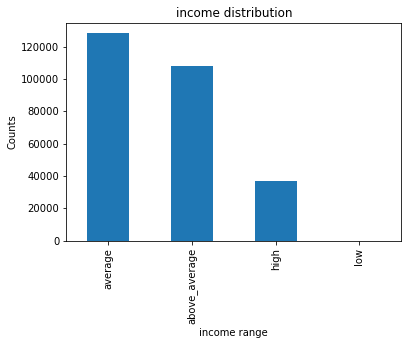

In [80]:
plt.figure()
starbucks_df['income_range'].value_counts().plot(kind='bar')
plt.xlabel("income range")
plt.ylabel("Counts")
plt.title("income distribution")

### - we can see that most starbucks customers have [average income between 30,000 and 59,999] or [above average between 60,000 and 89,999]


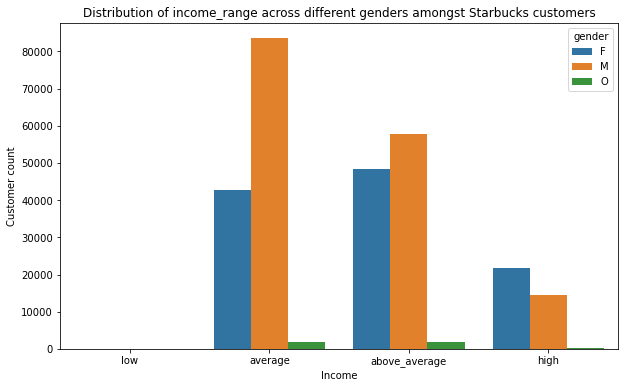

In [81]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x="income_range", hue="gender", data=starbucks_df)
plt.title('Distribution of income_range across different genders amongst Starbucks customers')
plt.ylabel('Customer count')
plt.xlabel('Income')
xlabels = ['low','average','above_average','high']
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='gender')
plt.show();

### - average and above average income customers are mostly males, except high income customers, who earn more than 90,000 are mostly females.

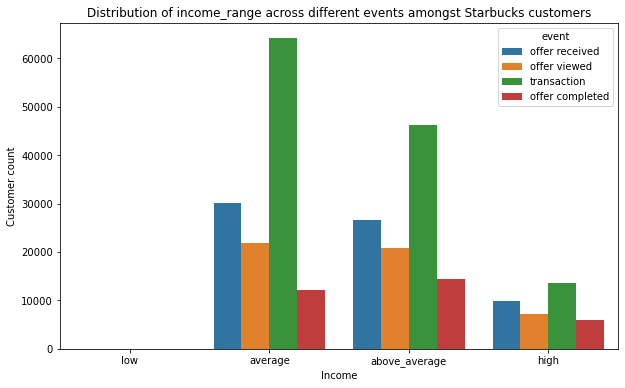

In [269]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x="income_range", hue="event", data=starbucks_df)
plt.title('Distribution of income_range across different events amongst Starbucks customers')
plt.ylabel('Customer count')
plt.xlabel('Income')
xlabels = ['low','average','above_average','high']
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='event')
plt.show();

### - Starbucks target average and above_average income customer with offers more than high income customers, also above_average income customers complete offers more than average income customers

## What is the distribution of age_groups accross the dataset?

Text(0.5, 1.0, 'Age Groups distribution')

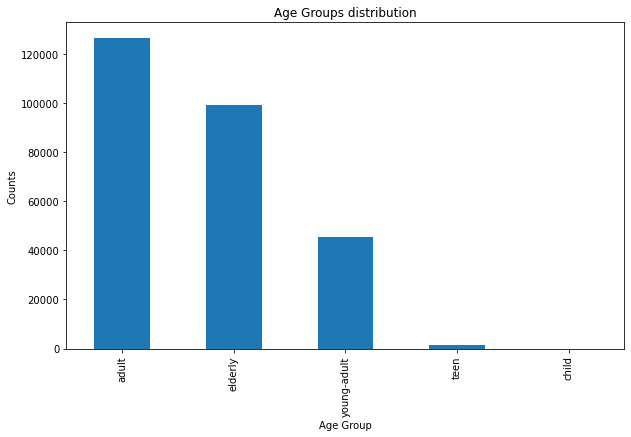

In [83]:
plt.figure(figsize=(10, 6))
starbucks_df['age_group'].value_counts().plot(kind='bar')
plt.xlabel("Age Group")
plt.ylabel("Counts")
plt.title("Age Groups distribution")

### - most customers are adults with ages ranging from (35 - 59), then elderly customers follow whos ages are 60+

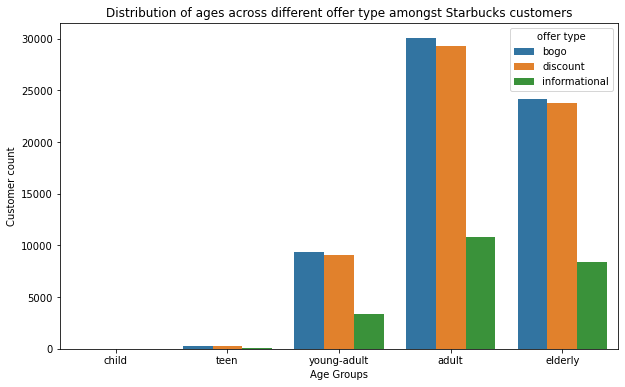

In [84]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x="age_group", hue="offer_type", data=starbucks_df)
plt.title('Distribution of ages across different offer type amongst Starbucks customers')
plt.ylabel('Customer count')
plt.xlabel('Age Groups')
xlabels = ['child','teen','young-adult','adult','elderly']
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='offer type')
plt.show();

## - bogo and discount offers are most popular across different age groups

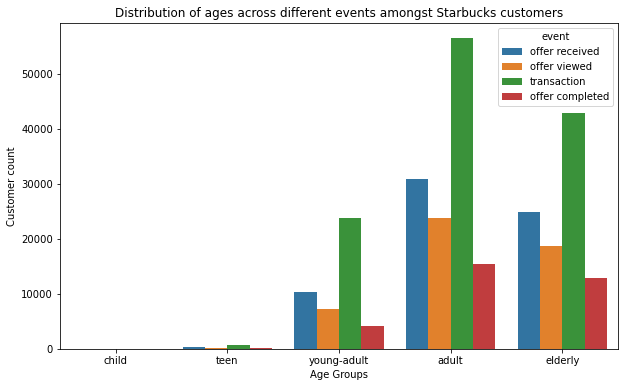

In [270]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x="age_group", hue="event", data=starbucks_df)
plt.title('Distribution of ages across different events amongst Starbucks customers')
plt.ylabel('Customer count')
plt.xlabel('Age Groups')
xlabels = ['child','teen','young-adult','adult','elderly']
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='event')
plt.show();

### - as expected ditributions follow the same trend accross multiple variables, none raises flags

## When did they become customers?

Text(0.5, 1.0, 'When did they join?')

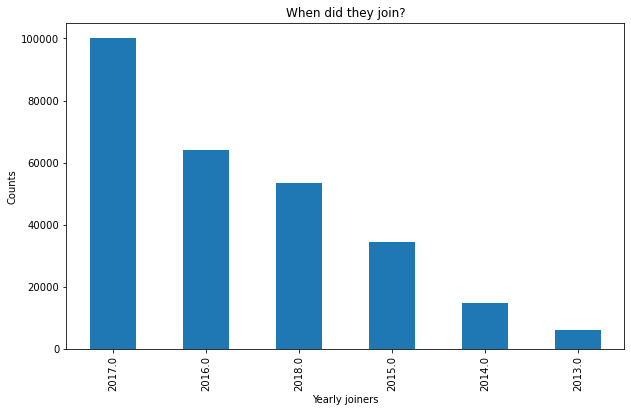

In [86]:
plt.figure(figsize=(10, 6))
starbucks_df['member_since'].value_counts().plot(kind='bar')
plt.xlabel("Yearly joiners")
plt.ylabel("Counts")
plt.title("When did they join?")

### mostly member joined starbucks in 2017, further research should be carried out to understand what drove this magnitude of new customers

# basically a successful offer is defined as an offer that is viewed then completed, therefore, in the following cells we will aim to create a dataframe of all successful offers in order to study the demographics of these offers

In [87]:
# create a dataframe of successful offers, we understand that a successful offer is viewed and completed
sorted_starbucks_df = starbucks_df.sort_values(by=['customer_id','hrs_time'])
sorted_starbucks_df = sorted_starbucks_df.reset_index()

In [88]:
successful_offer = pd.DataFrame(columns = sorted_starbucks_df.columns)

for i in range(len(sorted_starbucks_df)):
    if sorted_starbucks_df.iloc[i]['event'] == 'offer viewed':
        if sorted_starbucks_df.iloc[i+2]['event'] == 'offer completed':
            row = sorted_starbucks_df[sorted_starbucks_df['index'] == sorted_starbucks_df.iloc[i][0]]
            successful_offer = successful_offer.append(row)
            
            

In [89]:
info_success = successful_offer[successful_offer['offer_type'] == 'informational'].shape[0]
info_all = starbucks_df[starbucks_df['offer_type'] == 'informational'].shape[0]
disc_success = successful_offer[successful_offer['offer_type'] == 'discount'].shape[0]
disc_all = starbucks_df[starbucks_df['offer_type'] == 'discount'].shape[0]
bogo_success = successful_offer[successful_offer['offer_type'] == 'bogo'].shape[0]
bogo_all = starbucks_df[starbucks_df['offer_type'] == 'bogo'].shape[0]

print("in our dataset we have {} successful offers".format(successful_offer.shape[0]))
print("{}% of informational offers are successful".format(int((info_success/info_all)*100)))
print("{}% of discount offers are successful".format(int((disc_success/disc_all)*100)))
print("{}% of bogo offers are successful".format(int((bogo_success/bogo_all)*100)))

in our dataset we have 16797 successful offers
1% of informational offers are successful
12% of discount offers are successful
13% of bogo offers are successful


## what is the distribution of offer types amongst successful offers?

Text(0.5, 1.0, 'distribution of offer types across successful offers')

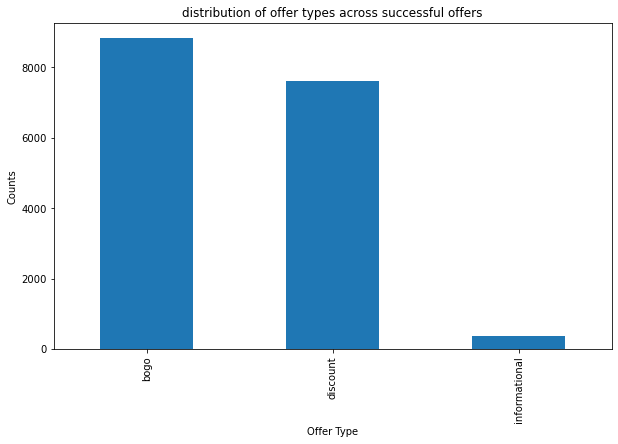

In [90]:
plt.figure(figsize=(10, 6))
successful_offer['offer_type'].value_counts().plot(kind='bar')
plt.xlabel("Offer Type")
plt.ylabel("Counts")
plt.title("distribution of offer types across successful offers")

### - the distribution of offer_types across successful offers is quite similar to all offers, were bogo offers are most successful, then discount, then informational. 

## what is the distribution of income range / gender / age group amongst types of successful offers?

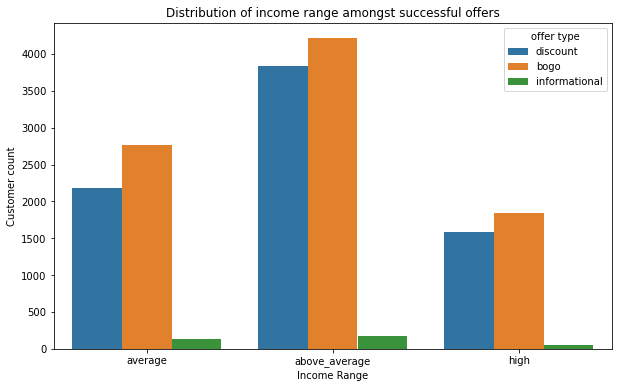

In [91]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x="income_range", hue="offer_type", data=successful_offer)
plt.title('Distribution of income range amongst successful offers')
plt.ylabel('Customer count')
plt.xlabel('Income Range')
xlabels = ['average','above_average','high']
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='offer type')
plt.show();

### offers sent to customers with above average income were most successful 

In [92]:
successful_offer.gender.unique()

array(['O', 'F', 'M'], dtype=object)

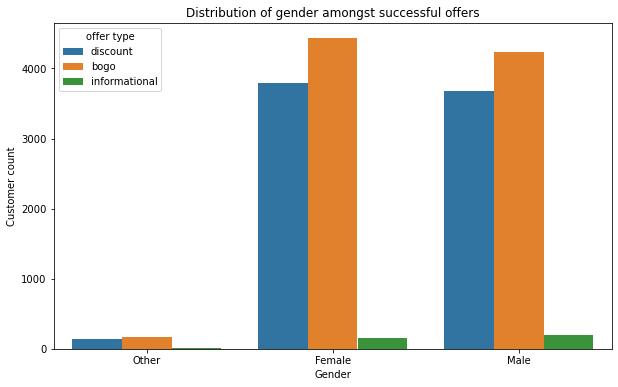

In [93]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x="gender", hue="offer_type", data=successful_offer)
plt.title('Distribution of gender amongst successful offers')
plt.ylabel('Customer count')
plt.xlabel('Gender')
xlabels = ['Other','Female', 'Male']
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='offer type')
plt.show();

### it is clear to see that females make more successful offer than males, and like most of the dataset, prefer BOGO offers

In [94]:
successful_offer.age_group.unique()

array(['adult', 'young-adult', 'elderly', 'teen'], dtype=object)

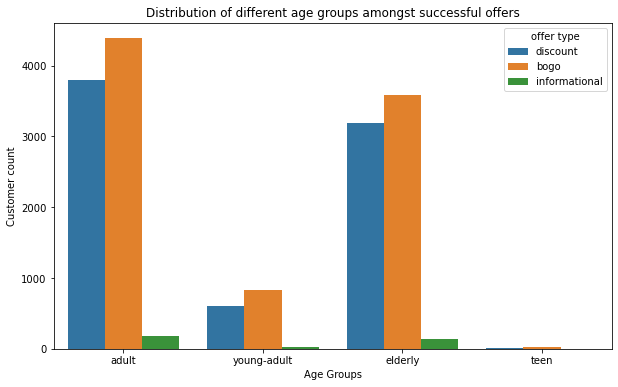

In [95]:
plt.figure(figsize=(10, 6))
plot = sns.countplot(x="age_group", hue="offer_type", data=successful_offer)
plt.title('Distribution of different age groups amongst successful offers')
plt.ylabel('Customer count')
plt.xlabel('Age Groups')
xlabels = ['adult','young-adult', 'elderly','teen']
plot.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='offer type')
plt.show();

### adults make more successful offers, and again, prefer BOGO offers

## *As explained in business understanding section, some customer are not interested in offers and will make transactions nevertheless. therefore, it is best to identify these kind of customers so as not to target them with offers. In the following cells we will aim to create a dataframe of all records of transactions made after recieving an offer and before viewing it, in order to study the demographics of these customers*

In [96]:
tot_trans = sorted_starbucks_df[sorted_starbucks_df['event'] == 'transaction'].shape[0]

In [97]:
no_offer_needed = pd.DataFrame(columns = sorted_starbucks_df.columns)

for i in range(len(sorted_starbucks_df)):
    if sorted_starbucks_df.iloc[i]['event'] == 'offer received':
        if sorted_starbucks_df.iloc[i+1]['event'] == 'transaction':
            row = sorted_starbucks_df[sorted_starbucks_df['index'] == sorted_starbucks_df.iloc[i+1][0]]
            no_offer_needed = no_offer_needed.append(row)

In [271]:
print('total transactions made without successfully completing recieved offers {}'.format(no_offer_needed.shape[0]))
print('percentage of such transactions over all transactions is {}%'.format(int((no_offer_needed.shape[0]/tot_trans)*100)))
print('total revenue generated from such transactions is {}'.format(no_offer_needed['amount'].sum()))

total transactions made without successfully completing recieved offers 18917
percentage of such transactions over all transactions is 15%
total revenue generated from such transactions is 261236.1


## what is the distribution of income range / gender / age group of customers who do not respond to offers and, nevertheless, make transactions?

Text(0.5, 1.0, 'Distribution of income across customers who does not respond to offers and, make transactions anyways?')

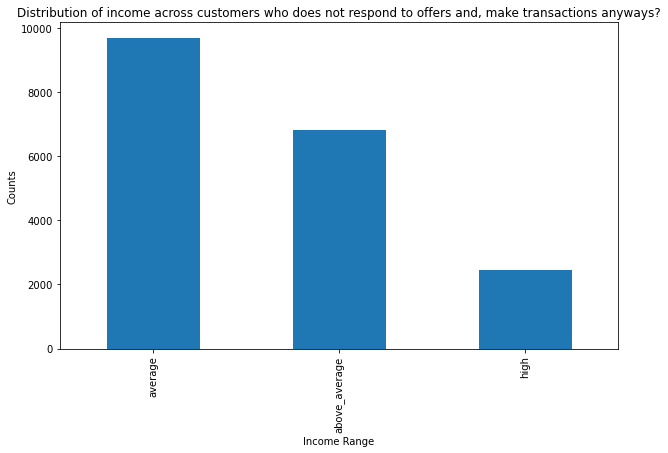

In [99]:
plt.figure(figsize=(10, 6))
no_offer_needed['income_range'].value_counts().plot(kind='bar')
plt.xlabel("Income Range")
plt.ylabel("Counts")
plt.title("Distribution of income across customers who does not respond to offers and, make transactions anyways?")

Text(0.5, 1.0, 'Distribution of gender across customers who do not respond to offers and, make transactions anyways?')

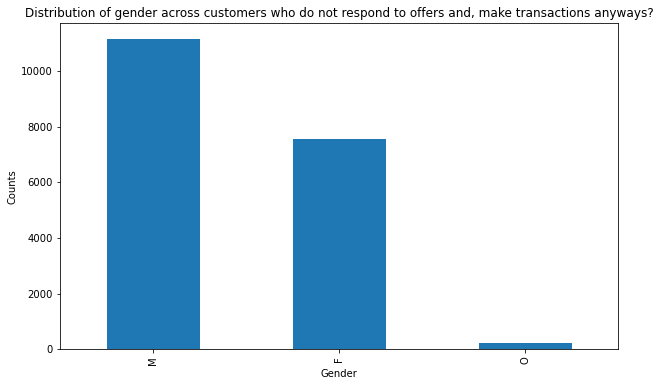

In [100]:
plt.figure(figsize=(10, 6))
no_offer_needed['gender'].value_counts().plot(kind='bar')
plt.xlabel("Gender")
plt.ylabel("Counts")
plt.title("Distribution of gender across customers who do not respond to offers and, make transactions anyways?")

Text(0.5, 1.0, 'Distribution of age groups across customers who do not respond to offers and, make transactions anyways?')

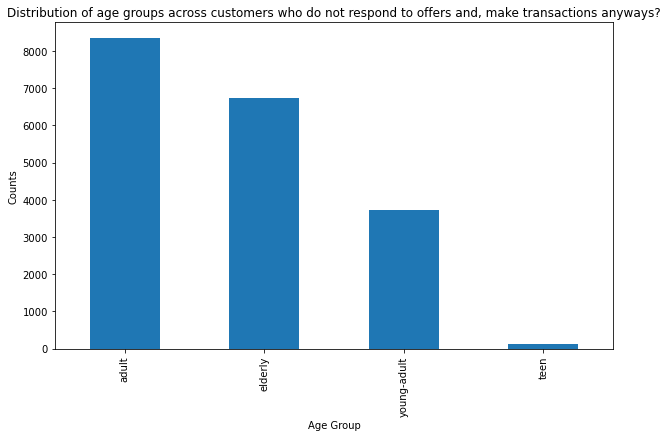

In [101]:
plt.figure(figsize=(10, 6))
no_offer_needed['age_group'].value_counts().plot(kind='bar')
plt.xlabel("Age Group")
plt.ylabel("Counts")
plt.title("Distribution of age groups across customers who do not respond to offers and, make transactions anyways?")

In [102]:
adult_seg = no_offer_needed[no_offer_needed['age_group'] == 'adult']
no_offer_needed_male_adult = adult_seg[adult_seg['gender']== 'M']
no_offer_needed_male_adult.shape[0]

4964

In [103]:
all_adults = sorted_starbucks_df[sorted_starbucks_df['age_group']=='adult']
all_male_adult = all_adults[all_adults['gender']=='M']

all_male_adult.shape[0]

73171

In [104]:
print('{}% of adult male customers do not respond to offers and make transactions anyways'.format(int((no_offer_needed_male_adult.shape[0]/all_male_adult.shape[0])*100)))

6% of adult male customers do not respond to offers and make transactions anyways


Text(0.5, 1.0, 'Distribution of ages of male adults who do not respond to offers and make transactions anyways')

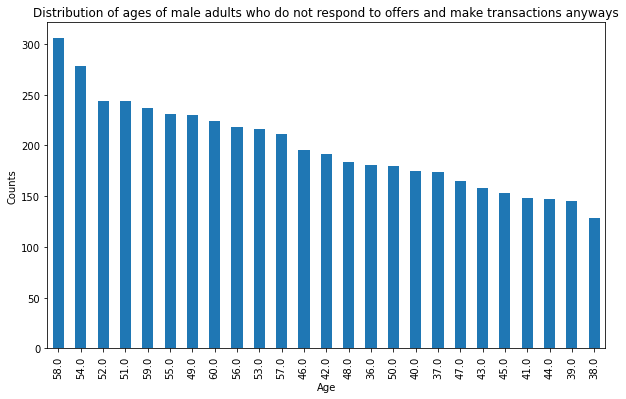

In [105]:
plt.figure(figsize=(10, 6))
no_offer_needed_male_adult['age'].value_counts().plot(kind='bar')
plt.xlabel("Age")
plt.ylabel("Counts")
plt.title("Distribution of ages of male adults who do not respond to offers and make transactions anyways")

## most customer who do not respond to offers and, make transactions anyways, are male adults who earn an average level of income. This segments represents 6% of all adult male customers, and most of them are 58 years old.

# 5. Data Modeling:

in this step we plan to create three models:
    - model to predict if an offer is feasible to be sent to an individual
    - model to predict if an offer is successful
    - model to predict the type of offer to send to an individual demographic

## a. preparing data for modeling:

In [113]:
join_df = no_offer_needed[['index','no_offer_needed']]
join_df

,index,no_offer_needed
6,168412,1
10,228422,1
15,258883,1
50,218935,1
85,82588,1
...,...,...
272692,269950,1
272704,258277,1
272725,265667,1
272753,214716,1


In [114]:
sorted_starbucks_df = sorted_starbucks_df.merge(join_df, on = 'index', how='left')
sorted_starbucks_df

,index,customer_id,event,hrs_time,amount,offer_id,reward_x,reward_y,difficulty,offer_type,...,social_channel,web_channel,hrs_duration,gender,age,income,age_group,member_since,income_range,no_offer_needed
0,55972,1,offer received,168,0.00,6,0.0,0.0,0.0,informational,...,1.0,0.0,72.0,M,33.0,72000.0,young-adult,2017.0,above_average,NaN
1,77705,1,offer viewed,192,0.00,6,0.0,0.0,0.0,informational,...,1.0,0.0,72.0,M,33.0,72000.0,young-adult,2017.0,above_average,NaN
2,89291,1,transaction,228,22.16,Not an Offer,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,M,33.0,72000.0,young-adult,2017.0,above_average,NaN
3,113605,1,offer received,336,0.00,4,0.0,0.0,0.0,informational,...,0.0,1.0,96.0,M,33.0,72000.0,young-adult,2017.0,above_average,NaN
4,139992,1,offer viewed,372,0.00,4,0.0,0.0,0.0,informational,...,0.0,1.0,96.0,M,33.0,72000.0,young-adult,2017.0,above_average,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,258361,14825,transaction,576,14.23,Not an Offer,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,F,45.0,62000.0,adult,2016.0,above_average,1.0
272758,258362,14825,offer completed,576,0.00,3,2.0,2.0,10.0,discount,...,0.0,1.0,168.0,F,45.0,62000.0,adult,2016.0,above_average,NaN
272759,262475,14825,offer viewed,582,0.00,3,0.0,2.0,10.0,discount,...,0.0,1.0,168.0,F,45.0,62000.0,adult,2016.0,above_average,NaN
272760,274809,14825,transaction,606,10.12,Not an Offer,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,F,45.0,62000.0,adult,2016.0,above_average,NaN


In [117]:
sorted_starbucks_df['no_offer_needed'] = sorted_starbucks_df['no_offer_needed'].fillna(0)

In [119]:
successful_offer['successful_offer'] = 1

In [120]:
join_df_2 = successful_offer[['index','successful_offer']]

In [121]:
sorted_starbucks_df = sorted_starbucks_df.merge(join_df_2, on = 'index', how='left')

In [156]:
sorted_starbucks_df['successful_offer'] = sorted_starbucks_df['successful_offer'].fillna(0)

In [194]:
# create a new dataframe for modeling:
model_starbucks_df = sorted_starbucks_df.copy()

In [195]:
model_starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   index             272762 non-null  object  
 1   customer_id       272762 non-null  object  
 2   event             272762 non-null  object  
 3   hrs_time          272762 non-null  int64   
 4   amount            272762 non-null  float64 
 5   offer_id          272762 non-null  object  
 6   reward_x          272762 non-null  float64 
 7   reward_y          148805 non-null  float64 
 8   difficulty        148805 non-null  float64 
 9   offer_type        148805 non-null  object  
 10  email_channel     148805 non-null  float64 
 11  mobile_channel    148805 non-null  float64 
 12  social_channel    148805 non-null  float64 
 13  web_channel       148805 non-null  float64 
 14  hrs_duration      148805 non-null  float64 
 15  gender            272762 non-null  object  
 16  ag

#### now we need to do the following:
    1. drop 'index' column
    2. transform 'event' column to have numerical values
    3. Fill NA values in 'reward_y'column
    4. Fill NA values in 'difficulty'column
    5. deal with NA values and transform 'offer_type' column to have numerical values
    6. Fill NA values in 'email_channel' column
    7. Fill NA values in 'mobile_channel' column
    8. Fill NA values in 'social_channel' column
    9. Fill NA values in 'web_channel' column
    10. Fill NA values in 'hrs_duration' column
    11. get dummies of 'gender' column
    12. transform 'age_group' column to have numerical values
    13. transform 'income_range' column to have numerical values

In [196]:
# 1. drop 'index' column
model_starbucks_df.drop('index', axis='columns', inplace=True)

In [197]:
# 2. transform 'event' column to have numerical values
event_list = model_starbucks_df['event'].astype('category').cat.categories.tolist()
event_dict = {'event' : {i: j for i,j in zip(event_list,list(range(1,len(event_list)+1)))}}
model_starbucks_df.replace(event_dict, inplace=True)

In [198]:
print('this is a reference to the dictionary of event values: \n {}'.format(event_dict))

this is a reference to the dictionary of event values: 
 {'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}


In [199]:
# 3. Fill NA values in 'reward_y'column
model_starbucks_df['reward_y'] = model_starbucks_df['reward_y'].fillna(0)

In [200]:
# 4. Fill NA values in 'difficulty'column
model_starbucks_df['difficulty'] = model_starbucks_df['difficulty'].fillna(0)

In [201]:
# 5. deal with NA values and transform 'offer_type' column to have numerical values
model_starbucks_df['offer_type'] = model_starbucks_df['offer_type'].fillna('transaction NOT offer')

In [202]:
# 5. deal with NA values and transform 'offer_type' column to have numerical values
offer_t_list = model_starbucks_df['offer_type'].astype('category').cat.categories.tolist()
offer_t_dict = {'offer_type' : {i: j for i,j in zip(offer_t_list,list(range(1,len(offer_t_list)+1)))}}
model_starbucks_df.replace(offer_t_dict, inplace=True)

In [203]:
print('this is a reference to the dictionary of offer_type values: \n {}'.format(offer_t_dict))

this is a reference to the dictionary of offer_type values: 
 {'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3, 'transaction NOT offer': 4}}


In [204]:
# 6. Fill NA values in 'email_channel' column
model_starbucks_df['email_channel'] = model_starbucks_df['email_channel'].fillna(0)

In [205]:
# 7. Fill NA values in 'mobile_channel' column
model_starbucks_df['mobile_channel'] = model_starbucks_df['mobile_channel'].fillna(0)

In [206]:
# 8. Fill NA values in 'social_channel' column
model_starbucks_df['social_channel'] = model_starbucks_df['social_channel'].fillna(0)

In [207]:
# 9. Fill NA values in 'web_channel' column
model_starbucks_df['web_channel'] = model_starbucks_df['web_channel'].fillna(0)

In [208]:
# 10. Fill NA values in 'hrs_duration' column
model_starbucks_df['hrs_duration'] = model_starbucks_df['hrs_duration'].fillna(0)

In [215]:
# 11. get dummies of 'gender' column
model_starbucks_df = pd.concat([model_starbucks_df.drop('gender', axis=1), pd.get_dummies(model_starbucks_df['gender'], prefix='gender', prefix_sep='_')], axis=1)

In [219]:
# change types of oue dummy column to int:
model_starbucks_df['gender_F'] = model_starbucks_df['gender_F'].astype('int')
model_starbucks_df['gender_M'] = model_starbucks_df['gender_M'].astype('int')
model_starbucks_df['gender_O'] = model_starbucks_df['gender_O'].astype('int')

In [221]:
# 12. transform 'age_group' column to have numerical values
age_group_list = model_starbucks_df['age_group'].astype('category').cat.categories.tolist()
age_group_dict = {'age_group' : {i: j for i,j in zip(age_group_list,list(range(1,len(age_group_list)+1)))}}
model_starbucks_df.replace(age_group_dict, inplace=True)

In [222]:
print('this is a reference to the dictionary of age_group values: \n {}'.format(age_group_dict))

this is a reference to the dictionary of age_group values: 
 {'age_group': {'child': 1, 'teen': 2, 'young-adult': 3, 'adult': 4, 'elderly': 5}}


In [223]:
# 13. transform 'income_range' column to have numerical values
income_range_list = model_starbucks_df['income_range'].astype('category').cat.categories.tolist()
income_range_dict = {'income_range' : {i: j for i,j in zip(income_range_list,list(range(1,len(income_range_list)+1)))}}
model_starbucks_df.replace(income_range_dict, inplace=True)

In [272]:
print('this is a reference to the dictionary of income_range values: \n {}'.format(income_range_dict))

this is a reference to the dictionary of income_range values: 
 {'income_range': {'low': 1, 'average': 2, 'above_average': 3, 'high': 4}}


In [225]:
model_starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       272762 non-null  object 
 1   event             272762 non-null  int64  
 2   hrs_time          272762 non-null  int64  
 3   amount            272762 non-null  float64
 4   offer_id          272762 non-null  object 
 5   reward_x          272762 non-null  float64
 6   reward_y          272762 non-null  float64
 7   difficulty        272762 non-null  float64
 8   offer_type        272762 non-null  int64  
 9   email_channel     272762 non-null  float64
 10  mobile_channel    272762 non-null  float64
 11  social_channel    272762 non-null  float64
 12  web_channel       272762 non-null  float64
 13  hrs_duration      272762 non-null  float64
 14  age               272762 non-null  float64
 15  income            272762 non-null  float64
 16  age_group         27

#### now our model_starbucks_df dataframe is ready for modeling



## b. data modeling
recap: we will be creating the following models:     
    - model to predict if an offer is feasable to be sent to an individual using K-Nearest Neighbors (will the customer return and make purchases without offers)
    - model to predict if an offer is successful using K-Nearest Neighbors
    - model to predict the type of offer to send to an individual demographic using Random Forest

In [263]:
def predict(pipeline, x_test, y_test):
    '''
    INPUT:
    pipeline - a fitted model to predict on
    x_test - part of our dataset to predict on
    y_test - part of our data set to test the performance of the prediction
    
    
    OUTPUT:
    prints a performance report of the pipeline's prediction  represented in 
    confusion_matrix, accuracy, recall, precision, , f1-score
    
    '''
    pred = pipeline.predict(x_test)
    pip_confusion_matrix = confusion_matrix(y_test, pred)
    pip_accuracy = accuracy_score(y_test, pred)
    pip_recall = recall_score(y_test, pred, average=None)
    pip_precision = precision_score(y_test, pred, average=None)
    pip_f1_score = f1_score(y_test, pred, average=None)


    print('The Confusion Matrix of our model is {}'.format(pip_confusion_matrix))
    print('The Accuracy of our model is {}'.format(pip_accuracy))
    print('The Recall of our model is {}'.format(pip_recall))
    print('The Precision of our model is {}'.format(pip_precision))
    print('The f1_score of our model is {}'.format(pip_f1_score))

### 1. predict if an offer is feasible to be sent to an individual using K-Nearest Neighbors:

In [264]:
# choosing features for our model:
y = model_starbucks_df['no_offer_needed']
x = model_starbucks_df[['event', 'hrs_time','amount','reward_x','age', 'income', 'age_group', 'member_since', 
                        'income_range','gender_F', 'gender_M','gender_O']]
#split our dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=42)

#instantiate the model
#building pipeline
steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]
pipeline_trans = Pipeline(steps)

#fit the pipeline
pipeline_trans.fit(x_train, y_train)

#make prediction and print the report 
predict(pipeline_trans, x_test, y_test)


The Confusion Matrix of our model is [[75049  1088]
 [ 5365   327]]
The Accuracy of our model is 0.9211404269879871
The Recall of our model is [0.98570997 0.05744905]
The Precision of our model is [0.93328276 0.23109541]
The f1_score of our model is [0.95878021 0.09202195]


### 2. predict if an offer is successful using K-Nearest Neighbors:

In [265]:
# choosing features for our model:
y = model_starbucks_df['successful_offer']
x = model_starbucks_df[['event', 'hrs_time','amount','reward_x','reward_y', 'difficulty','offer_type', 
                        'email_channel','mobile_channel', 'social_channel', 'web_channel', 'hrs_duration',
                        'age','income', 'age_group', 'member_since', 'income_range','gender_F', 'gender_M',
                        'gender_O']]
#split our dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=42)

#instantiate the model
#building pipeline
steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]
pipeline_success = Pipeline(steps)

#fit the pipeline
pipeline_success.fit(x_train, y_train)

#make prediction and print the report 
predict(pipeline_success, x_test, y_test)

The Confusion Matrix of our model is [[74787  1976]
 [ 2585  2481]]
The Accuracy of our model is 0.9442618142712241
The Recall of our model is [0.97425843 0.48973549]
The Precision of our model is [0.96658998 0.55665246]
The f1_score of our model is [0.97040906 0.52105429]


### 3. predict the type of offer to send to an individual demographic using Random Forest:

In [266]:
# choosing features for our model:
y = model_starbucks_df['offer_type']
x = model_starbucks_df[['event', 'hrs_time','amount','reward_x','reward_y', 'difficulty','offer_type', 
                        'email_channel','mobile_channel', 'social_channel', 'web_channel', 'hrs_duration',
                        'age','income', 'age_group', 'member_since', 'income_range','gender_F', 'gender_M',
                        'gender_O']]
#split our dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=42)

#instantiate the model
#building pipeline


steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor(n_estimators = 100, random_state = 42))]
pipeline_forest = Pipeline(steps)

#fit the pipeline
pipeline_forest.fit(x_train, y_train)

#make prediction and print the report 
predict(pipeline_forest, x_test, y_test)

The Confusion Matrix of our model is [[19046     0     0     0]
 [    0 18647     0     0]
 [    0     0  6766     0]
 [    0     0     0 37370]]
The Accuracy of our model is 1.0
The Recall of our model is [1. 1. 1. 1.]
The Precision of our model is [1. 1. 1. 1.]
The f1_score of our model is [1. 1. 1. 1.]


#### our 3 models performed very well, therefore, and in-order to avoid overfitting we will not use GridSearchcv

# Conclusion:

1. Most Starbucks customers earn an average income of [30,000: 59,999], or above average of [60,000: 89,999], these customers earning average and above average income are mostly males. However, customers earning high income [+90,000] are mostly females. Furthermore, looking at the relationship between income_range and event columns, we can quickly see that Starbucks target average and above_average income customer with offers more than high income customers, also above_average income customers complete offers more than average income customers.


2. Most Starbucks customers are adults with ages ranging from [35: 59], and elderly customers follows whos’ ages are +60. Also, we can see that BOGO (buy one get one free) and discount offers are most popular across different age groups. Furthermore, looking at the distribution of events across age_groups, we see that, as the expected behaviour, distributions follow the same trend accross multiple variables, none raises specific flags.


3.	Mostly member joined Starbucks in 2017, further research should be carried out to understand what drove this magnitude of new customers in 2017.


4.	A successful offer is defined as an offer that is viewed then completed, therefore, we created a dataframe of all successful offers in order to study the demographics of these offers. In our dataset, there are 16797 successful offers, comparing between sucessful offers and total offers I found the following results: 
    1.	1% of total informational offers are successful
    2.	12% of total discount offers are successful
    3.	13% of total bogo offers are successful

   The distribution of offer_types across successful offers is quite similar to all offers, were bogo offers are most successful, then discount, then informational. Furthermore, looking at the relationship between successful offers and incom_range, it confirms that above average customers respond best to offers, sincce offers sent to customers with above average income were most successful. Looking further, it is clear to see that females make more successful offer than males, and like most of the dataset, prefer BOGO offers. Also, generally adults make more successful offers, and again, prefer BOGO offers.


5. A pure transaction is defined by the sequence of receiving an offer, and making a transaction without viewing the offer. Therefore, it was very important to create a data-frame of all pure transactions to study it and later flag recodrs in the main data-frame as pure transaction or not. After creating the data-frame we found the following: 
    1.	Total pure transactions are 18917 transactions
    2.	15% of total transactions are pure transactions not influenced by an offer
    3.	Total revenue generated from such transactions is $261236 
    
   Looking at the demographics of customers who make pure transactions, I found the following: Mostly male adults earning an average level of income would make pure transactions, this segment of customers represent 6% of all adult male customers, and most of them are 58 years old.



# Reflection

working on the Starbuck datasets was pretty challenging and fun to tackle. the data set was quite complicated and required a good amount of exploration to better understanding.
However, the more you look into a problem, the less creative, you would be to think out of the box. Therefore, I took time in the analysis part to manage the threshold, and defined the models to work on initially.
But, the most important takeout to note is, no matter how complex the dataset could be, do not focus on how overwhelming it is, just tackle it with a clear mind and enjoy solving the complexity.

# Improvement

currently i would suggest two point if improvement:

1. Trying several classification models, and choose the best one.
2. While defining the pure transaction dataset, I could have added the logic to identify transactions that were made after the period of offer influence defined in the portfolio dataset.